## Implementing DDPM from Scratch

In the DL Deep Dive on Diffusion, I am going to implement **Denoising Diffusion Probabilistic Models** or DDPMs for short from scratch using PyTorch. I will be referring to the paper by [Ho et al](https://arxiv.org/abs/2006.11239) which is among the first papers to introduce Diffusion Models. 


<div style="background-color: rgba(147, 51, 234, 0.1); padding: 10px; border-radius: 5px;">
 Popular models currently using Diffusion Models at its core include <a href="https://openai.com/dall-e-2/">DALL-E 2</a> by OpenAI, <a href="https://github.com/CompVis/latent-diffusion">Latent Diffusion</a> by the University of Heidelberg and <a href="https://imagen.research.google/">ImageGen</a> by Deepmind among many others.
</div>

The idea of Diffusion Models was inspired from non-equilibrium statistical thermodynamics and were first introduced by [Sohl-Dickstein et al., 2015](https://arxiv.org/abs/1503.03585) at Stanford. There exist many variations and approaches to applying Diffusion Models in CV tasks, here we'll be primarily focused on implementing in PyTorch the original TensorFlow codebase by [Ho et al](https://arxiv.org/abs/2006.11239).

## What is a Diffusion Model?

## Investivating the DataSet

We are working with the FGVCAircraft dataset. The dataset contains around 6667 images across 100 different aircraft variants. Each image is labeled with bounding box annotations and multiple levels of aircraft categorization, making it useful for both classification and detection tasks.

The dataset consists of images of aircraft taken from different viewpoints, with annotations specifying:

- The aircraft manufacturer (e.g., Boeing, Airbus)
- The specific model (e.g., Boeing 747-400)
- The aircraft family/variant

However, we are building a generative model and so don't care about specifics about the images. What we care about is making sure all images are of the same size.

In [136]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt

In [137]:
def show_ds(dataset, num_samples=10, cols=5):
    plt.figure(figsize=(20, 10))
    
    for i, image in enumerate(dataset):
        if i >= num_samples:
            break
            
        plt.subplot(num_samples//cols + 1, cols, i+1)
        plt.imshow(image[0])
    
    plt.tight_layout()
    plt.axis('off')
    plt.show()

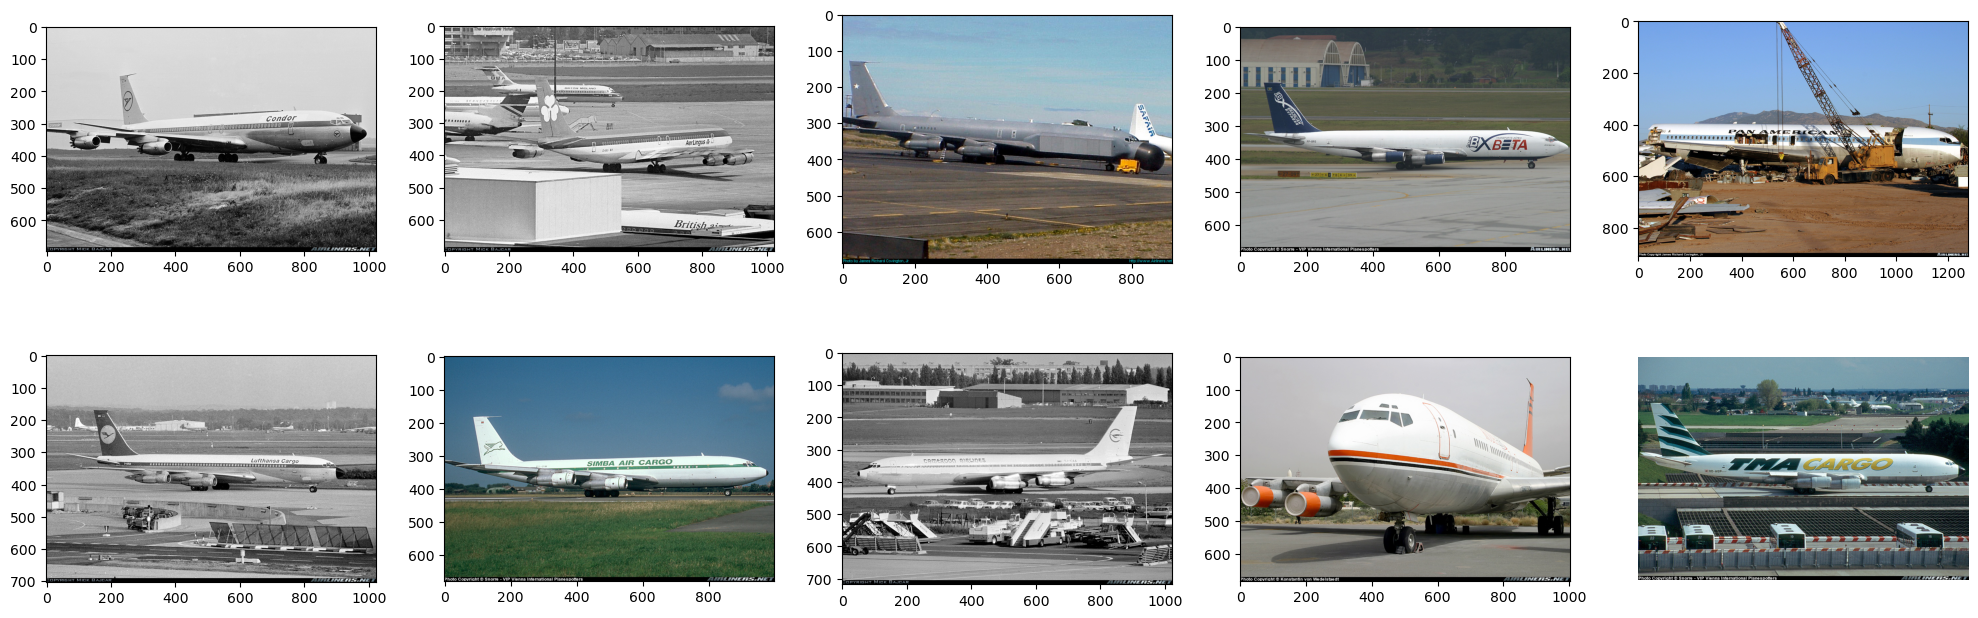

In [138]:
data = datasets.FGVCAircraft(root='.', download=True)
show_ds(data)

In [139]:
print(f"The total samples in the dataset is {len(data)}")

The total samples in the dataset is 6667


## The Diffusion Model: the Forward & Backward Process

### The Forward Process: Noise Scheduler

Diffusion Models like many other generative models such as GANs or VAEs convert noise from a distribution to a data sample. The forward process, in essense, does one thing: add noise to the images.

The forward process is markov process which is denoted by $q$ that gradually adds Gaussian Noise to the images until the result is pure noise.

$$q(\mathbf{x_{1:T}}|\mathbf{x_0}) = \prod_{t=1}^T q(\mathbf{x_{t}}|\mathbf{x_{t-1}})$$

This forward process is iterated using $t$ over $T$ steps. For example, [Ho et al](https://arxiv.org/abs/2006.11239) chose a value of $\mathbf{T}=1000$. To explain this process simply, say you start off with a picture of an aircraft, $\mathbf{x_0}$ at $\mathbf{t=0}$. In the forward process, noise sampled from a Gaussian Distribution is added to $\mathbf{x_0}$ at $\mathbf{t=1}$ to form $\mathbf{x_1}$. Over large number of iterations of this process, noise accumulates leading to the image turning into an [Isotropic Gaussian Distribution](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic). Following is a visualisation of the forward process from [Stanford CS236](https://www.youtube.com/watch?v=VsllsC2JMGY)

![Forward Process Visualization](./forward.png)

Further mathematical granularity:

The following equation describes the process of getting to $\mathbf{x_t}$ from $\mathbf{x_{t-1}}$

$$q(\mathbf{x}_t|\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t\mathbf{I})$$

> $\mathcal{N}$ basically says, given $\mathbf{x}_{t-1}$, sample $\mathbf{x}_t$ from a Normal distribution with mean $\sqrt{1-\beta_t} \mathbf{x}_{t-1}$ and covariance matrix $\beta_t I$.

$\mathcal{N}(\mathbf{x}_t; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t\mathbf{I})$ represents the Gaussian Distribution centered at $\sqrt{1-\beta_t}\mathbf{x}_{t-1}$, which is a dimmer version of the original image, with a variance of $\beta_t\mathbf{I}$ where $\mathbf{I}$ is the identity matrix. Simply, $\mathbf{x}_{t}$ is created by adding a dimmer version of the previous image, $\sqrt{1-\beta_t}\mathbf{x}_{t-1}$ with noise scaled by the calculated variance, $\beta_t\mathbf{I}$

### Here is a code snippet demonstrating the Forward Diffusion Process over one step:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4327009277719074..2.3275056748878193].


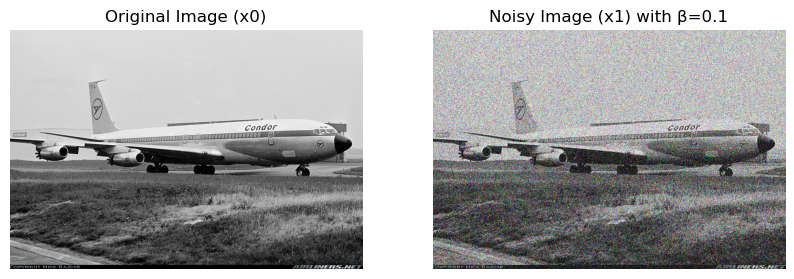

In [140]:
import numpy as np

bt = 0.1
at = 1-bt 
mean_scaling = np.sqrt(at) # Mean Scaling Factor
var_scaling = np.sqrt(bt) # Variance Scaling Factor

x0 = np.array(data[0][0]).astype(np.float32)/255.0 # Normalise x0
noise = np.random.normal(size=x0.shape)
x1 = mean_scaling * x0 + var_scaling * noise

# Plotting
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)  # (rows, columns, index) - indices start at 1, not 0
plt.imshow(x0)
plt.title('Original Image (x0)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x1)
plt.title(f'Noisy Image (x1) with β={bt}')
plt.axis('off')

plt.show()

### How to choose the $\beta$?

When working with diffusion models, there's an important asymmetry between how we add and remove noise. During the forward process of adding noise, we can use a mathematical shortcut called cumulative products. This works because noise addition follows a predictable, deterministic pattern - mathematically, adding noise gradually or jumping directly to a specific noise level produces equivalent results. This shortcut is particularly valuable during training, where we need to efficiently create many examples at different noise levels.

However, the reverse process of denoising must follow a strictly step-by-step approach. The model learns specifically how to transition between adjacent timesteps, removing noise gradually from one step to the next. This iterative nature is fundamental because each denoising step depends on the image's state from the previous step. The model has been trained to understand these small, incremental transitions rather than large jumps in noise levels.

This asymmetry exists because adding noise is a straightforward process we can control and mathematically optimize, while removing noise is a complex transformation that the model must learn through training. It's similar to how you can quickly mix paint colors together, but separating them back into their original colors requires a careful, step-by-step process. This is why we can use shortcuts in the forward process but must maintain the iterative approach in the reverse process.

There are various ways to 'schedule' the $\beta$'s, primarily: 

- Linear schedule: β increases linearly
- Cosine schedule (introduced by OpenAI's Improved DDPM): Often works better as it preserves more information early on
- Exponential schedule: β grows exponentially

In [141]:
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")

def linear_betas(T, start=0.0001, end=0.2):
    return torch.linspace(start, end, T, device=device)  # Create directly on device

def forwardiff(x0, t, T):  # Note: T is timesteps, not device
    # Move input to device
    x0 = x0.to(device)
    t = t.to(device)
    
    # Get beta schedule
    betas = linear_betas(T, 0.0001, 0.02) 
    alphas = 1-betas
    
    # Calculate cumulative products of alphas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    
    batch_size = x0.shape[0]
    alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1)
    
    # Generate random noise
    noise = torch.randn_like(x0, device=device)
    
    # Calculate noisy image
    noisy_image = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    
    return noisy_image, noise

In [142]:
import torch.utils.data
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

def transform_ds():
    data_transforms = [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]

    transform = transforms.Compose(data_transforms)

    train = datasets.FGVCAircraft(root='.', download=True, transform=transform)
    test = datasets.FGVCAircraft(root='.', download=True, transform=transform, split='test')

    return torch.utils.data.ConcatDataset([train, test])

def tensor_to_image(image):
    # First move image to CPU
    image = image.cpu()  # Add this line
    
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = transform_ds()
dataloader = DataLoader(data, batch_size=8, shuffle=True, drop_last=True)

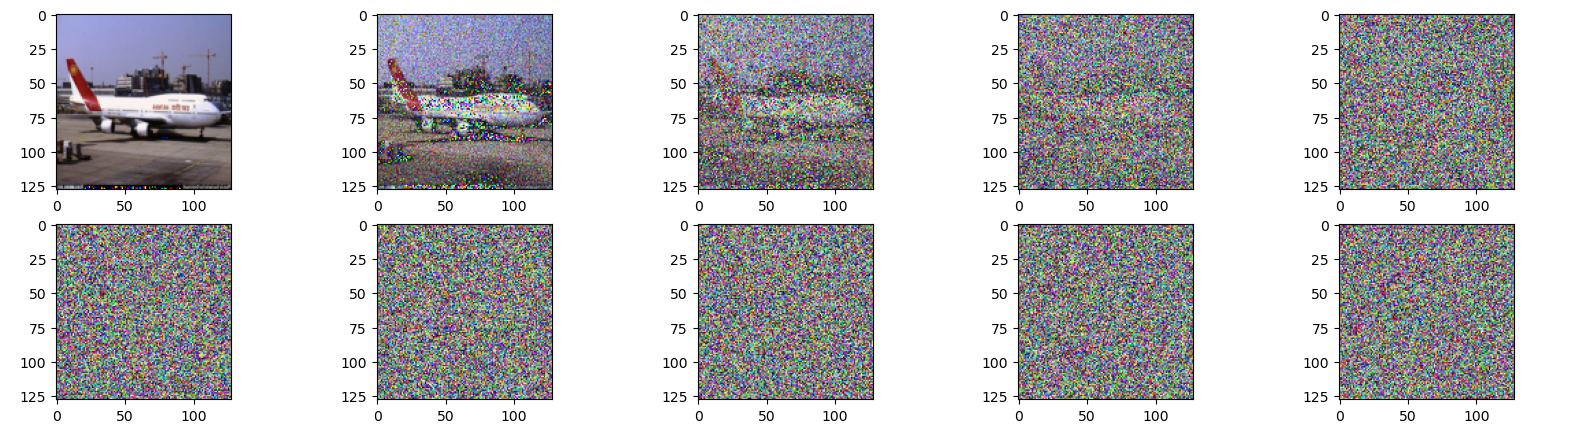

In [143]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]
plt.figure(figsize=(20, 5))  # Adjusted figure size for 2x5 layout
plt.axis('off')
num_images = 10
T = 500
stepsize = max(1, int(T/num_images))

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    # Changed subplot to 2 rows, 5 columns
    plt.subplot(2, 5, int(idx/stepsize) + 1)
    img, noise = forwardiff(image, t, T)
    tensor_to_image(img)

plt.show()

## Backward Process using U-Nets

Now that there is noise in the image, if we knew a conditional distribution $p({\mathbf{x}_{t-1}|\mathbf{x}_{t}})$, the forward process can be run in reverse to generate a high-res image from a noisy one. This $p$ can be learnt using Neural Networks, U-nets in particular and is called $p_{\theta}$ where $\theta$ represents the parameters of the NN. Assuming the reverse process to also be Gaussian, we need two parameters: (1) the mean, $\mu_{\theta}$ and (2) the variance, $\Sigma_{\theta}$ which we choose to keep constant like the authors of DDPM. 

$$p_\theta(\mathbf{x}_{0:T}) = p(\mathbf{x}_T)\prod_{t=1}^T p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t) \quad p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t,t), \mathbf{\Sigma}_\theta(\mathbf{x}_t,t))$$

Through some clever math, we can derieve the equation for the mean added at step $\mathbf{x}_{t+1}$ to get $\mathbf{x}_{t}$: 

$$\mu_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\alpha_t}}\epsilon_\theta(\mathbf{x}_t, t)\right)$$

The final objective function $L_t$ then looks as follows (for a random time step $t$ given $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\text{):}$

$$\|\epsilon - \epsilon_\theta(\mathbf{x}_t, t)\|^2 = \|\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{(1-\bar{\alpha}_t)}\epsilon, t)\|^2$$

I have implemented U-Nets [before](https://github.com/ahitagnied/deep-learning/blob/main/01-deep-neural-networks/015-u-nets/u-nets.ipynb). U-nets are nice because their outputs have the same shape as their inputs, it can be easily seen why it could be of use in this particular application using Diffusion Models. U-Nets have a downsampling and upsampling path using Convolutional Layers and implement skip connectiions and residuals. The U-Net is implemented in the **Reverse Denoising Diffusion Process**, $p_{\theta}$ where the U-Net is trained to gradually denoise an image starting from pure noise, until you end up with an actual image.

In [144]:
import torch.nn as nn
import math

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dim_tembedding, up=False):
        super().__init__()

        if up:
            self.conv1 = nn.Conv2d(2* in_channels, out_channels, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            self.transform = nn.Conv2d(out_channels, out_channels, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        self.time_mlp = nn.Linear(dim_tembedding, out_channels)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU()
    
    def forward(self, x, t):
        # First Convolutional Layer
        c = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Match dimensions to broadcasr to c
        time_emb = time_emb.reshape(*time_emb.shape, 1, 1)
        # Broadcase to c
        c = c + time_emb
        # Second Convolutional Layer
        c = self.bnorm2(self.relu(self.conv2(c)))
        # Down/ Up-sample
        return self.transform(c)

class SinPosEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        in_channels = 3
        down = (128, 256, 512, 1024)
        up = (1024, 512, 256, 128)
        out_channels = 3

        temd = 8

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinPosEmbedding(temd),
                nn.Linear(temd, temd),
                nn.ReLU()
            )
        
        self.conv0 = nn.Conv2d(in_channels, down[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([ConvBlock(down[i], down[i+1], \
                                    temd) \
                    for i in range(len(down)-1)])
        # Upsample
        self.ups = nn.ModuleList([ConvBlock(up[i], up[i+1], \
                                        temd, up=True) \
                    for i in range(len(up)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up[-1], out_channels, 1)

    def forward(self, x, T):
        # Embedd time
        t = self.time_mlp(T)

        # Initial conv
        x = self.conv0(x)

        # Unet
        residual_inputs = []

        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)

        return self.output(x)
    
model = Unet()
print(f"Total # of paramers in the model is {sum(p.numel() for p in model.parameters())}")
model

Total # of paramers in the model is 61634507


Unet(
  (time_mlp): Sequential(
    (0): SinPosEmbedding()
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): ConvBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_mlp): Linear(in_features=8, out_features=256, bias=True)
      (bnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (con

In [145]:
def get_loss(model, x_0, t):
    # Pass T (timesteps) instead of device
    x_noisy, noise = forwardiff(x_0, t, T=300)  # or whatever your T value is
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Training!

In [146]:
# Define beta schedule
T = 300
betas = linear_betas(T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [155]:
@torch.no_grad()
def sample_timestep(x, t):
    # Move all constant tensors to the correct device if they aren't already
    global betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance
    betas = betas.to(device)
    sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
    sqrt_recip_alphas = sqrt_recip_alphas.to(device)
    posterior_variance = posterior_variance.to(device)
    
    batch_size = t.shape[0]
    
    betas_t = betas.gather(-1, t).reshape(batch_size, *((1,) * (len(x.shape) - 1)))
    
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(-1, t).reshape(batch_size, *((1,) * (len(x.shape) - 1)))
    
    sqrt_recip_alphas_t = sqrt_recip_alphas.gather(-1, t).reshape(batch_size, *((1,) * (len(x.shape) - 1)))
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    
    posterior_variance_t = posterior_variance.gather(-1, t).reshape(batch_size, *((1,) * (len(x.shape) - 1)))
    
    if t.item() == 0: 
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise
    

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = 128
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,1.5))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)
    subplot_idx = 1

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, subplot_idx)
            tensor_to_image(img.detach().cpu())
            subplot_idx += 1
    plt.show()        

Epoch 000 | step 000 | Loss: 0.1290 | Avg Loss: 0.1290


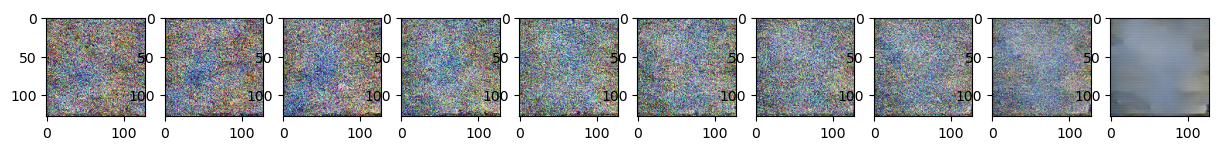

In [ ]:
from torch.optim import Adam
from tqdm import tqdm  # For progress bar

# Device setup
device = (
    "mps" 
    if torch.backends.mps.is_available() 
    and torch.backends.mps.is_built() 
    else "cpu"
)

# Model and optimizer setup
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
T = 300  

# Track losses for plotting
losses = []

for epoch in range(epochs):
    epoch_losses = []
    
    # Using tqdm for progress bar
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        
        # Generate random timesteps
        t = torch.randint(0, T, (batch[0].size(0),), device=device).long()
        
        # Move batch to device and compute loss
        loss = get_loss(model, batch[0].to(device), t)
        
        # Training step
        loss.backward()
        optimizer.step()
        
        # Track loss
        epoch_losses.append(loss.item())
        
        # Print progress and generate samples
        if epoch % 5 == 0 and step == 0:
            avg_loss = sum(epoch_losses) / len(epoch_losses)
            print(f"Epoch {epoch:03d} | step {step:03d} | Loss: {loss.item():.4f} | Avg Loss: {avg_loss:.4f}")
            sample_plot_image()
    
    # Track average epoch loss
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_epoch_loss)
    
    if epoch % 99 == 0:
        print(f"Epoch {epoch:03d} completed | Average Loss: {avg_epoch_loss:.4f}")